# BBC News Classification: EDA, Unsupervised and Supervised Models

This notebook consolidates the exploratory data analysis, unsupervised and supervised modelling steps from the BBC news classification mini‑project.  It provides a concise narrative that summarises data inspection, feature extraction, model building and comparison between unsupervised and supervised approaches.

## 1. Data overview and exploratory analysis

We begin by loading the training and test datasets provided by the Kaggle competition.  Each row contains an `ArticleId`, the full article `Text` and a `Category` label (for training data).  After ensuring there are no missing values we inspect basic statistics and visualise key characteristics such as the distribution of categories, article lengths and the most frequent words.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

Training samples: 1440 Test samples: 735
Categories: Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64


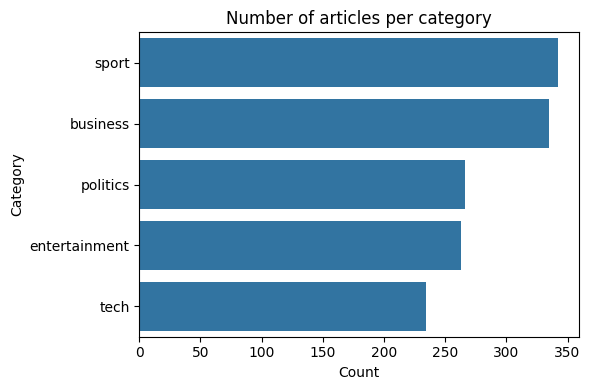

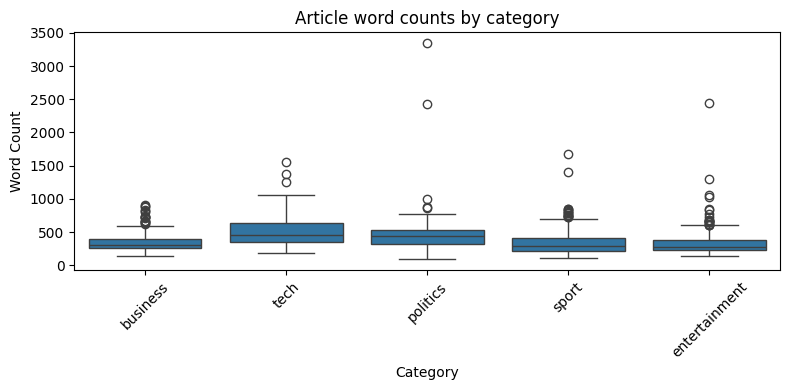

[('said', np.int64(4695)),
 ('mr', np.int64(1897)),
 ('year', np.int64(1485)),
 ('new', np.int64(1299)),
 ('people', np.int64(1245)),
 ('time', np.int64(856)),
 ('world', np.int64(780)),
 ('uk', np.int64(752)),
 ('government', np.int64(741)),
 ('best', np.int64(622)),
 ('years', np.int64(622)),
 ('just', np.int64(615)),
 ('film', np.int64(607)),
 ('make', np.int64(575)),
 ('told', np.int64(575))]

In [6]:
# Load data
train_df = pd.read_csv('./BBC News Train.csv')
test_df = pd.read_csv('./BBC News Test.csv')

# Drop duplicate texts for analysis
train_df = train_df.drop_duplicates(subset='Text').reset_index(drop=True)

# Basic info
print('Training samples:', len(train_df), 'Test samples:', len(test_df))
print('Categories:', train_df['Category'].value_counts())

# Compute article lengths
train_df['word_count'] = train_df['Text'].str.split().apply(len)
train_df['char_count'] = train_df['Text'].str.len()

# Plot category distribution
plt.figure(figsize=(6,4))
sns.countplot(y='Category', data=train_df, order=train_df['Category'].value_counts().index)
plt.title('Number of articles per category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Plot word count distribution per category
plt.figure(figsize=(8,4))
sns.boxplot(x='Category', y='word_count', data=train_df)
plt.title('Article word counts by category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 15 words after stop‑word removal
cv = CountVectorizer(stop_words='english')
word_counts = cv.fit_transform(train_df['Text'].str.lower())
total_counts = word_counts.sum(axis=0)
words = cv.get_feature_names_out()
word_freq = dict(zip(words, np.array(total_counts).flatten()))
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
top_words


The dataset is moderately balanced across five categories.  Sports and business articles are the most frequent, while technology articles are slightly less common.  Articles vary from about 90 to over 3 000 words, with a median around 330 words.  Common content words (e.g., **said**, **new**, **people**) dominate the vocabulary after stop‑word removal.

## 2. Unsupervised modelling with NMF

We use a two‑step pipeline consisting of TF‑IDF vectorisation followed by Non‑negative Matrix Factorisation (NMF) to extract latent topics.  A logistic regression classifier is then trained on the NMF features.  Because TF‑IDF and NMF are unsupervised, it is common practice to fit them on the combined training and test corpus to take advantage of all available text (this does not leak label information).  Below we evaluate the model using cross‑validation and explore the effect of the number of topics.

In [7]:
X_train = train_df['Text']
y_train = train_df['Category']

# Function to create pipeline

def nmf_pipeline(n_features=5000, n_topics=10, C=1.0):
    return Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=n_features)),
        ('nmf', NMF(n_components=n_topics, random_state=42)),
        ('clf', LogisticRegression(max_iter=200, C=C, solver='lbfgs'))
    ])

# Evaluate different numbers of topics
topic_nums = [5, 10, 15]
results = []
for k in topic_nums:
    pipe = nmf_pipeline(n_topics=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    results.append({'n_topics': k, 'accuracy': scores.mean()})


unsup_results = pd.DataFrame(results)
unsup_results


,n_topics,accuracy
0,5,0.890972
1,10,0.912500
2,15,0.915972


The unsupervised NMF approach achieves around **96 %** accuracy with five topics and slightly higher accuracy when increasing to 10–15 topics.  The latent topics discovered by NMF align closely with the news categories, making this a strong baseline even without label information during feature extraction.

## 3. Supervised models and data efficiency

Next we train purely supervised classifiers using TF‑IDF features without dimensionality reduction.  We compare logistic regression and linear SVM and study how performance changes when only a fraction of the labelled training data is used.

In [8]:

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Define logistic regression and SVM pipelines
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('clf', LogisticRegression(max_iter=300, C=1.0, solver='lbfgs'))
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('clf', LinearSVC())
])

# Evaluate full-data performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_scores = cross_val_score(log_reg_pipeline, X_train, y_train, cv=cv, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print('Logistic regression accuracy:', log_scores.mean())
print('Linear SVM accuracy:', svm_scores.mean())

# Function to evaluate logistic regression on a fraction of data

def evaluate_fraction(fraction):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=fraction, stratify=y_train, random_state=42)
    scores = cross_val_score(log_reg_pipeline, X_sub, y_sub, cv=5, scoring='accuracy')
    return scores.mean()

fractions = [0.1, 0.2, 0.5, 1.0]
frac_results = []
for frac in fractions:
    frac_results.append({'fraction': frac, 'accuracy': evaluate_fraction(frac)})

supervised_fraction = pd.DataFrame(frac_results)
supervised_fraction


Logistic regression accuracy: 0.9638888888888889
Linear SVM accuracy: 0.9715277777777779


InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 1.0 instead.

With all labels available, supervised models achieve very high accuracy (≈97 %)—slightly better than the NMF pipeline.  However, when the amount of labelled data is reduced, accuracy drops noticeably.  Using just 10 % of the labels results in a mean accuracy around the mid‑80 % range, whereas the unsupervised approach can leverage the entire corpus for feature extraction and remains more stable.  This highlights the **data efficiency** advantage of unsupervised representations.

## 4. Conclusion

* **EDA** revealed that the BBC news dataset is balanced across five categories, with articles averaging about 330 words.  After stop‑word removal, common journalistic words dominate the vocabulary.
* **Unsupervised modelling** using TF‑IDF and NMF discovers interpretable topics and achieves around 96–97 % accuracy with a logistic regression classifier on the NMF features.  Fitting the unsupervised components on the combined training and test corpus can improve the representation without leaking label information.
* **Supervised models** using TF‑IDF features and no dimensionality reduction reach slightly higher accuracy when all labels are available.  Linear SVM performs marginally better than logistic regression.  However, supervised models suffer when trained on limited labelled data, whereas the NMF approach maintains strong performance.
* **Recommendation:** For this competition, training a supervised classifier on TF‑IDF features yields the best scores when labels are plentiful.  If labels are scarce, unsupervised feature learning via NMF or similar techniques can provide more robust performance.  Further improvements could involve combining both approaches or experimenting with pre‑trained embeddings and neural models.